In [1]:
cd ..

/home/janek/reasonable-embeddings


In [2]:
import numpy as np
import pandas as pd
import torch as T
import torch.nn.functional as F
import torch.nn as nn
from sklearn import metrics

from src.reasoner_mod import *
from src.generate import load_dataset
from src.reasoner import *
from src.utils import *
from src.vis import *
import random

In [3]:
seed = 2022
dataset_path = 'local/out/dataset/sub-100.json'
ts = timestr()
train_onto, test_onto, data_tr, data_vl, data_te = load_dataset(dataset_path)

emb_size = 10
hidden_size = 16
epoch_count = 12
test_epoch_count = 22
batch_size = 32

T.manual_seed(seed)
random.seed(seed)
trained_reasoner = ModifiedReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
encoders = [ModifiedEmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in train_onto]

print(f'created reasoner with {paramcount(trained_reasoner)} parameters')
print(f'created {len(encoders)} encoders with {paramcount(encoders[0])} parameters each')

train_logger = train_mod(data_tr, data_vl, trained_reasoner, encoders, epoch_count=epoch_count, batch_size=batch_size, identities_weight=0.04, identitity_weight_decay=0.9)

created reasoner with 4493 parameters
created 40 encoders with 1270 parameters each
train epoch 00/12 | batch 2001/2000 | loss 1.1772 | val loss 0.6837 | acc 0.7691 | f1 0.1086 | prec 0.3065 | recall 0.0660 | roc auc 0.4410 | pr auc 0.2169 | elapsed 35.33s
train epoch 01/12 | batch 2001/2000 | loss 0.8576 | val loss 0.4675 | acc 0.8244 | f1 0.4242 | prec 0.7041 | recall 0.3035 | roc auc 0.7154 | pr auc 0.5422 | elapsed 95.38s
train epoch 02/12 | batch 2001/2000 | loss 0.5771 | val loss 0.3630 | acc 0.8625 | f1 0.5985 | prec 0.7923 | recall 0.4809 | roc auc 0.8388 | pr auc 0.7102 | elapsed 102.58s
train epoch 03/12 | batch 2001/2000 | loss 0.4364 | val loss 0.2884 | acc 0.8991 | f1 0.7282 | prec 0.8552 | recall 0.6340 | roc auc 0.8933 | pr auc 0.8140 | elapsed 97.05s
train epoch 04/12 | batch 2001/2000 | loss 0.3410 | val loss 0.2444 | acc 0.9171 | f1 0.7832 | prec 0.8851 | recall 0.7023 | roc auc 0.9179 | pr auc 0.8605 | elapsed 102.13s
train epoch 05/12 | batch 2001/2000 | loss 0.2784

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

data_test = pd.DataFrame({
    'ontology_id': data_te[0],
    'X': data_te[1],
    'y': data_te[2]
})

def stratified_group_split(data, group_col, stratify_col, test_size=0.2, val_size=0.2):
    groups = data[group_col].unique()
    train_idx, val_idx, test_idx = [], [], []

    for group in groups:
        group_data = data[data[group_col] == group]
        train_data, temp_data = train_test_split(group_data, test_size=(test_size + val_size), stratify=group_data[stratify_col])
        val_data, test_data = train_test_split(temp_data, test_size=test_size/(test_size + val_size), stratify=temp_data[stratify_col])

        train_idx.extend(train_data.index)
        val_idx.extend(val_data.index)
        test_idx.extend(test_data.index)

    return data.loc[train_idx], data.loc[val_idx], data.loc[test_idx]

train_data, val_data, test_data = stratified_group_split(data_test, 'ontology_id', 'y', test_size=0.2, val_size=0.2)

X_train = train_data['X'].tolist()
y_train = train_data['y'].tolist()
ontology_id_train = train_data['ontology_id'].tolist()

data_te_tr = [ontology_id_train,X_train, y_train] 

X_val = val_data['X'].tolist()
y_val = val_data['y'].tolist()
ontology_id_val = val_data['ontology_id'].tolist()

data_te_vl = [ontology_id_val, X_val, y_val] 

X_te = X_test = test_data['X'].tolist()
y_te = y_test = test_data['y'].tolist()
idx_te = ontology_id_test = test_data['ontology_id'].tolist()


In [5]:
## --- TESTING
trained_test_encoders = {}
T.manual_seed(seed)
random_reasoner = ReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
test_logger = TrainingLogger(validate=True, metrics=batch_stats)

for reasoner_name, reasoner in [('trained reasoner', trained_reasoner), ('random reasoner', random_reasoner)]:
    print(reasoner_name)
    T.manual_seed(seed)
    trained_test_encoders[reasoner_name] = test_encoders = [EmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in test_onto]
    if reasoner_name == 'trained reasoner':
        train_mod(data_te_tr, data_te_vl, reasoner, test_encoders, epoch_count=test_epoch_count, batch_size=batch_size, run_name=reasoner_name, freeze_reasoner=True, logger=test_logger,identities_weight=0.045, identitity_weight_decay=0.9)
    #else:
        #train(data_te, None, reasoner, test_encoders, epoch_count=test_epoch_count, batch_size=batch_size, run_name=reasoner_name, freeze_reasoner=True, logger=test_logger)

trained reasoner
train epoch 00/22 | batch 751/750 | loss 1.0517 | val loss 0.8982 | acc 0.7144 | f1 0.4094 | prec 0.3720 | recall 0.4552 | roc auc 0.6632 | pr auc 0.4881 | elapsed 10.88s
train epoch 01/22 | batch 751/750 | loss 0.9496 | val loss 0.7188 | acc 0.7610 | f1 0.4656 | prec 0.4532 | recall 0.4787 | roc auc 0.7155 | pr auc 0.5402 | elapsed 25.03s
train epoch 02/22 | batch 751/750 | loss 0.7477 | val loss 0.5792 | acc 0.7983 | f1 0.5242 | prec 0.5381 | recall 0.5109 | roc auc 0.7681 | pr auc 0.6032 | elapsed 25.51s
train epoch 03/22 | batch 751/750 | loss 0.5911 | val loss 0.4775 | acc 0.8329 | f1 0.5930 | prec 0.6304 | recall 0.5598 | roc auc 0.8134 | pr auc 0.6678 | elapsed 25.51s
train epoch 04/22 | batch 751/750 | loss 0.4755 | val loss 0.4032 | acc 0.8542 | f1 0.6388 | prec 0.6929 | recall 0.5925 | roc auc 0.8500 | pr auc 0.7265 | elapsed 24.61s
train epoch 05/22 | batch 751/750 | loss 0.3907 | val loss 0.3497 | acc 0.8721 | f1 0.6832 | prec 0.7408 | recall 0.6339 | roc a

In [6]:
with T.no_grad():
    # idx_te, X_te, y_te = data_te
    _, _, Y_te_good = eval_batch_mod(trained_reasoner, trained_test_encoders['trained reasoner'], X_te, y_te, idx_te)
    #_, _, Y_te_rand = eval_batch(random_reasoner, trained_test_encoders['random reasoner'], X_te, y_te, idx_te)

local/out/exp/20240710T214740


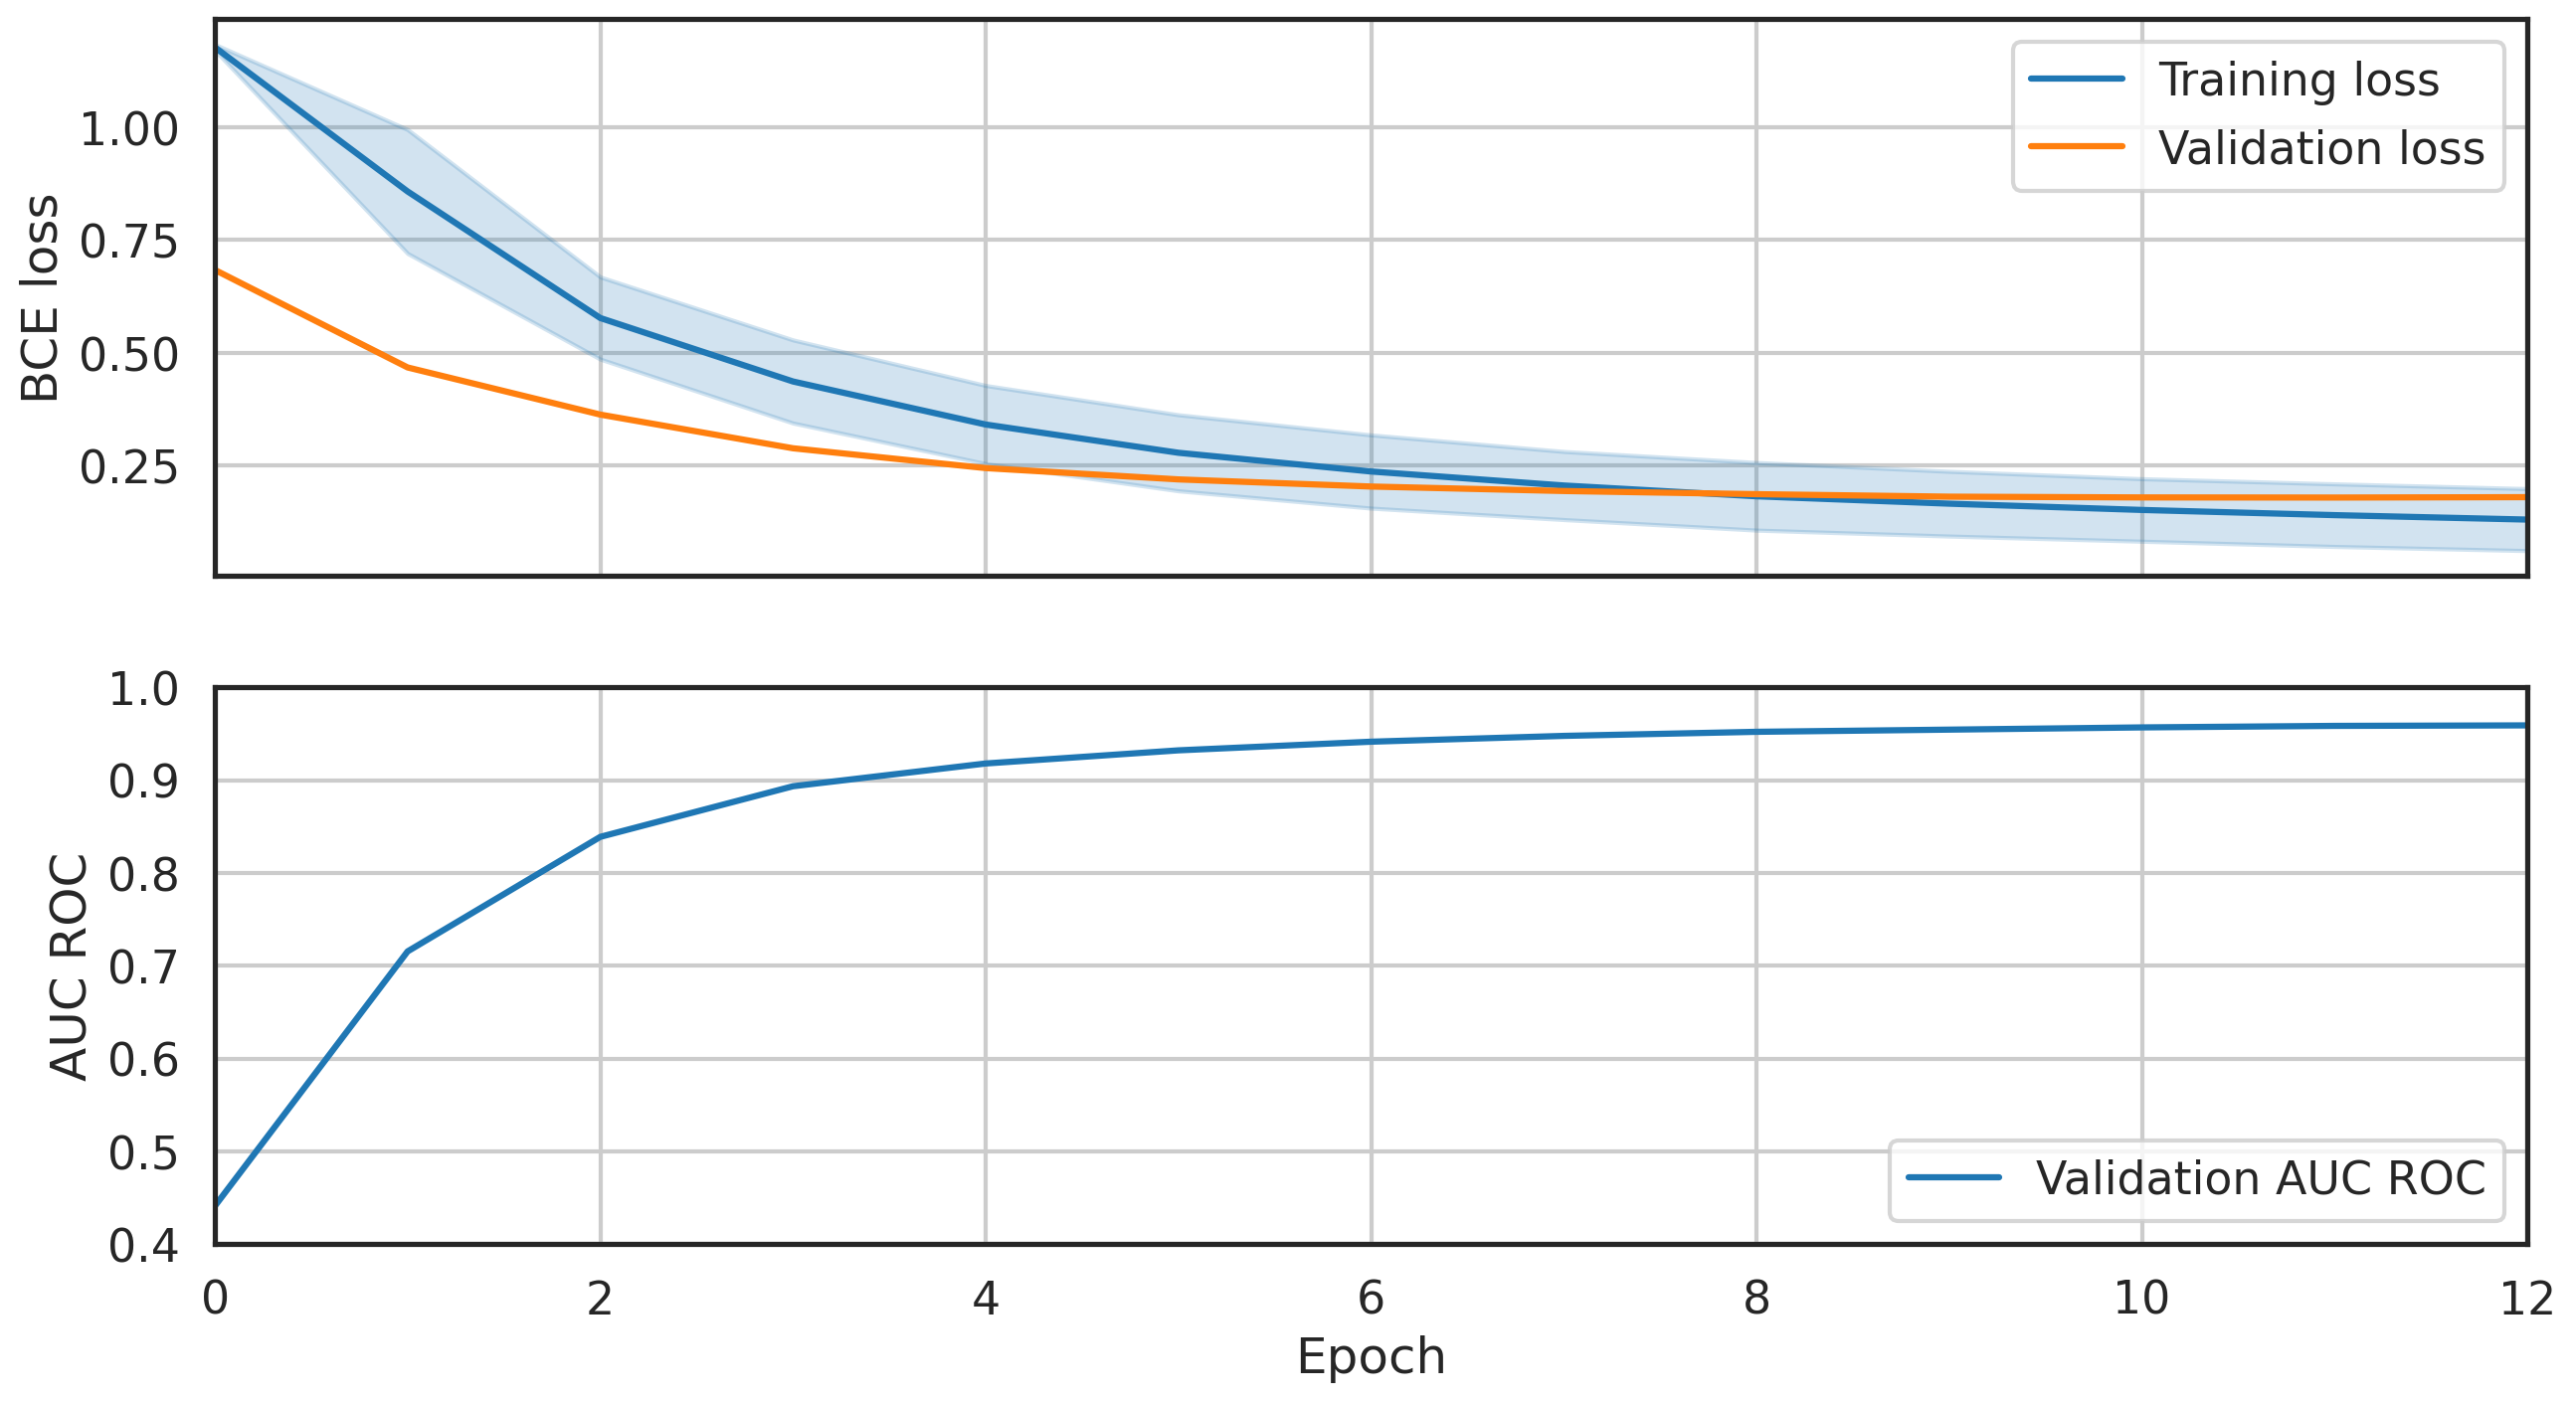

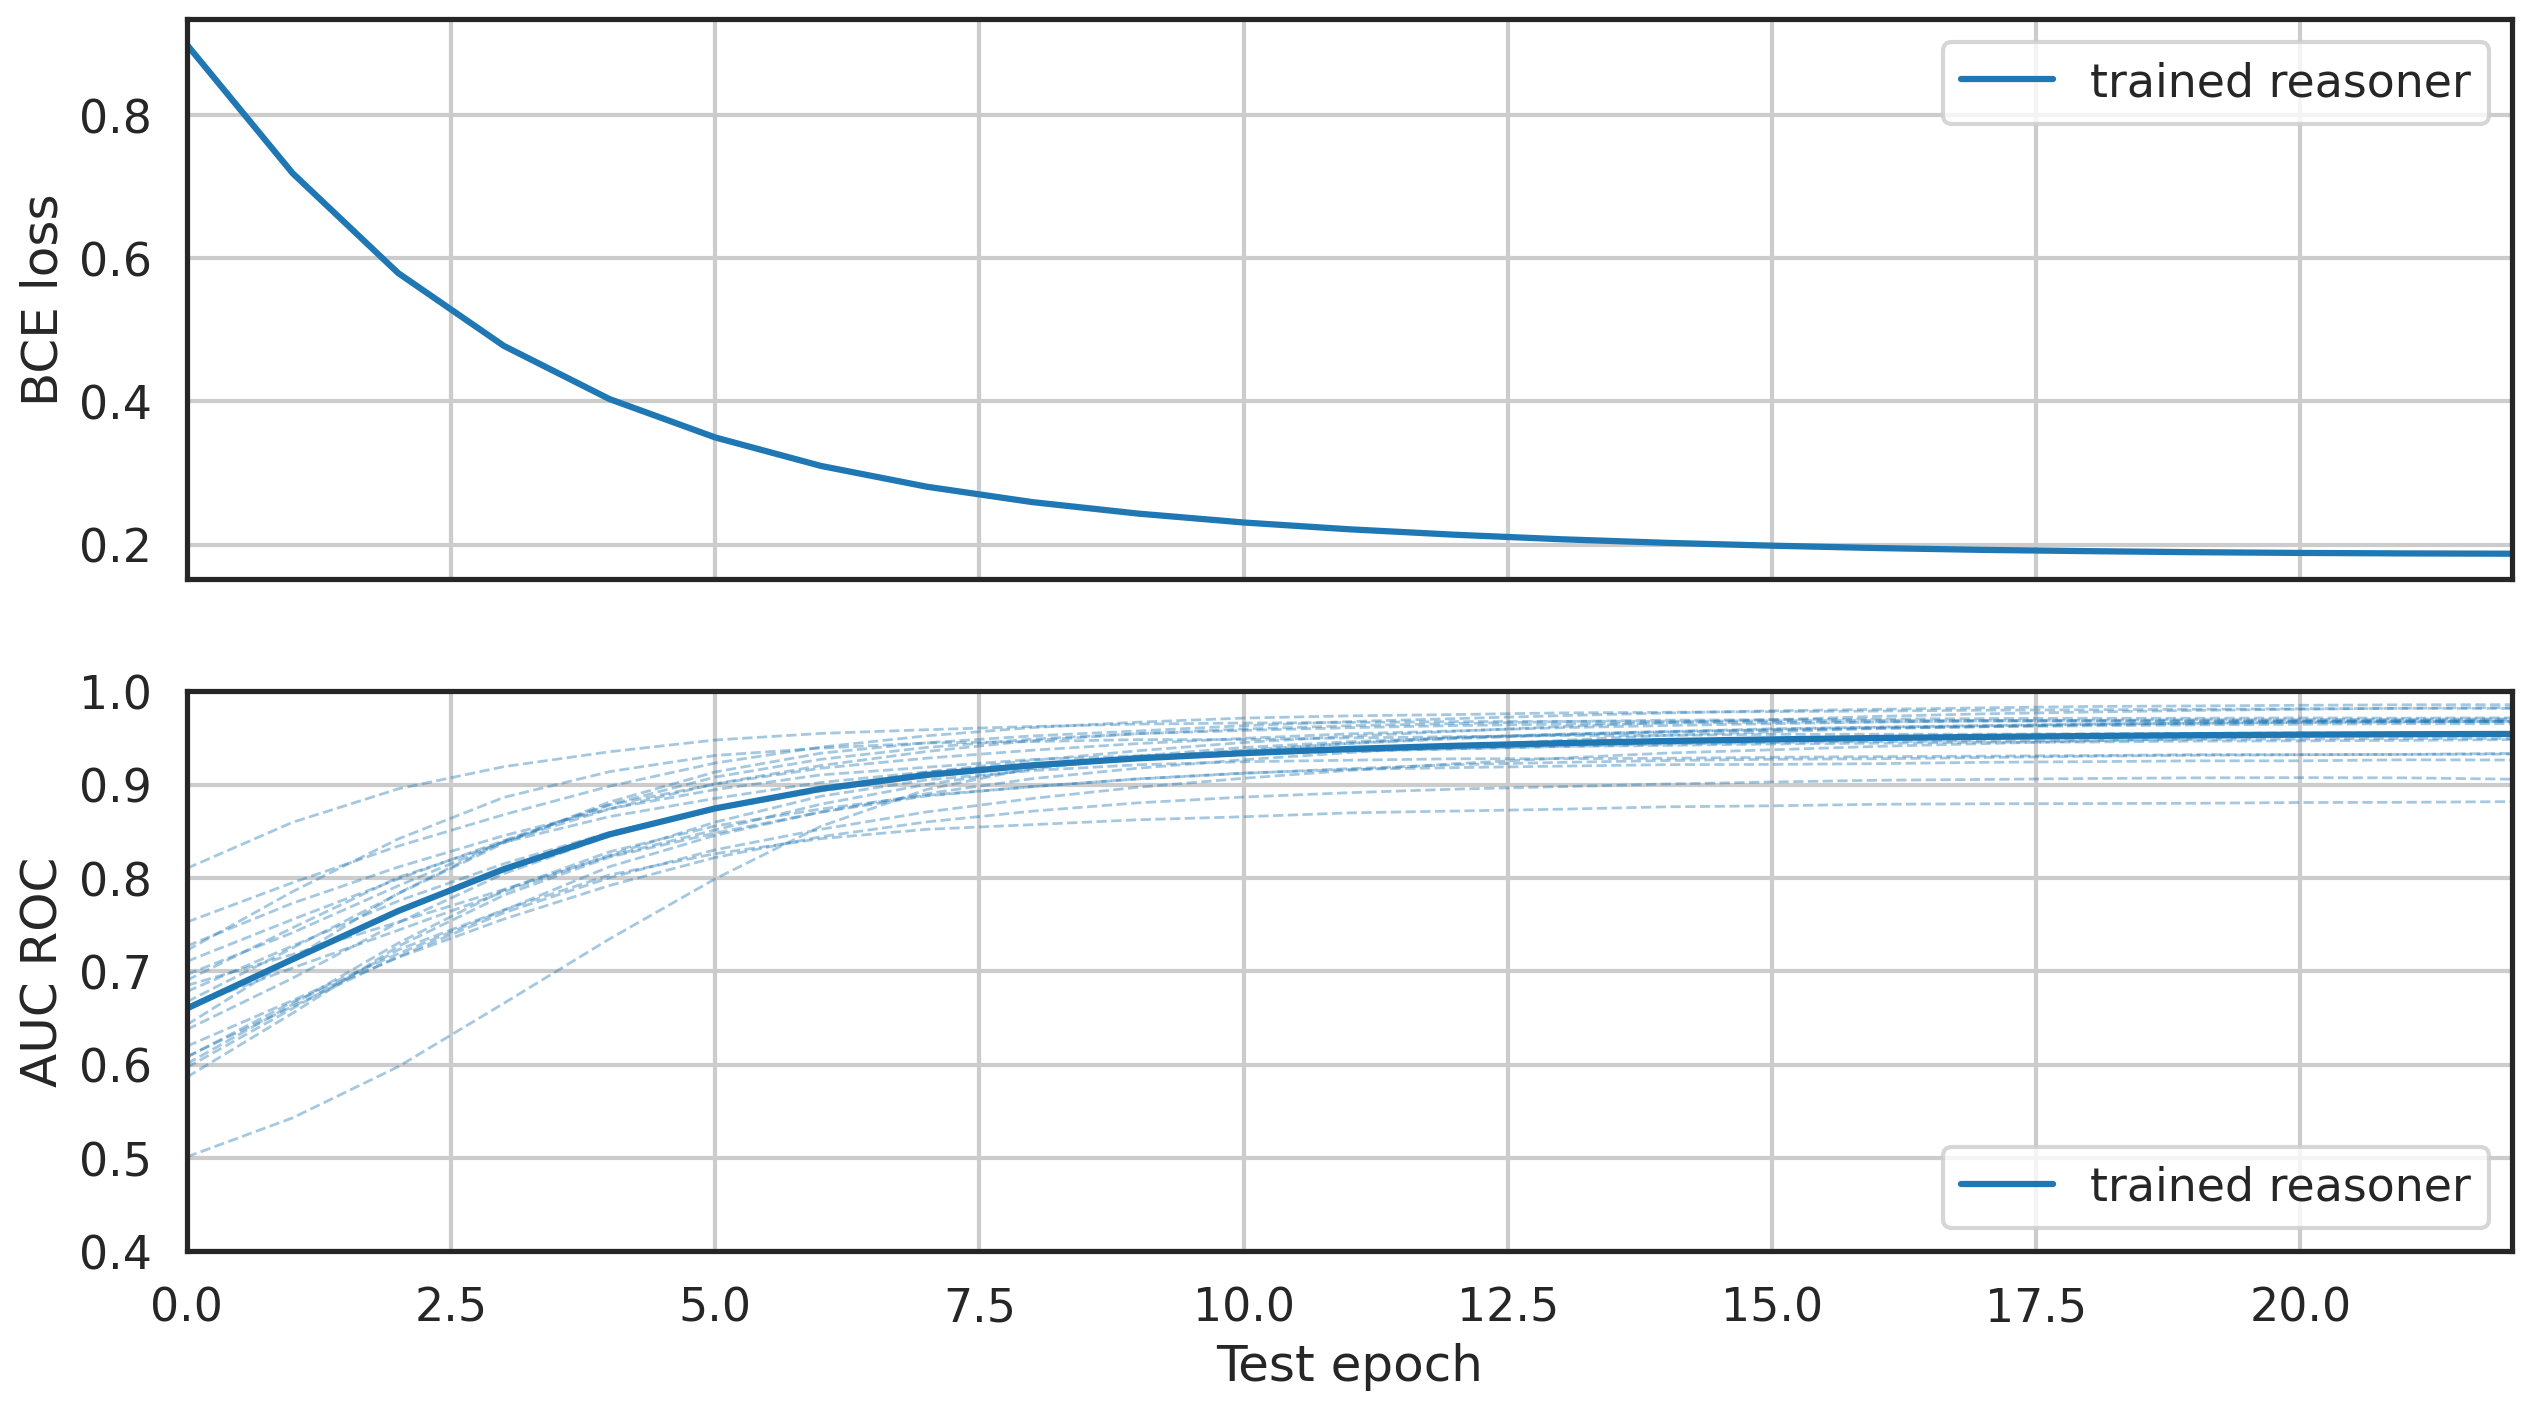

             mean       std     micro
acc      0.936875  0.022882  0.936875
prec     0.876439  0.059291  0.876679
recall   0.823054  0.067190  0.825762
f1       0.848072  0.057904  0.850459
auc_roc  0.948609  0.018945  0.951060
auc_pr   0.913364  0.038791  0.918415


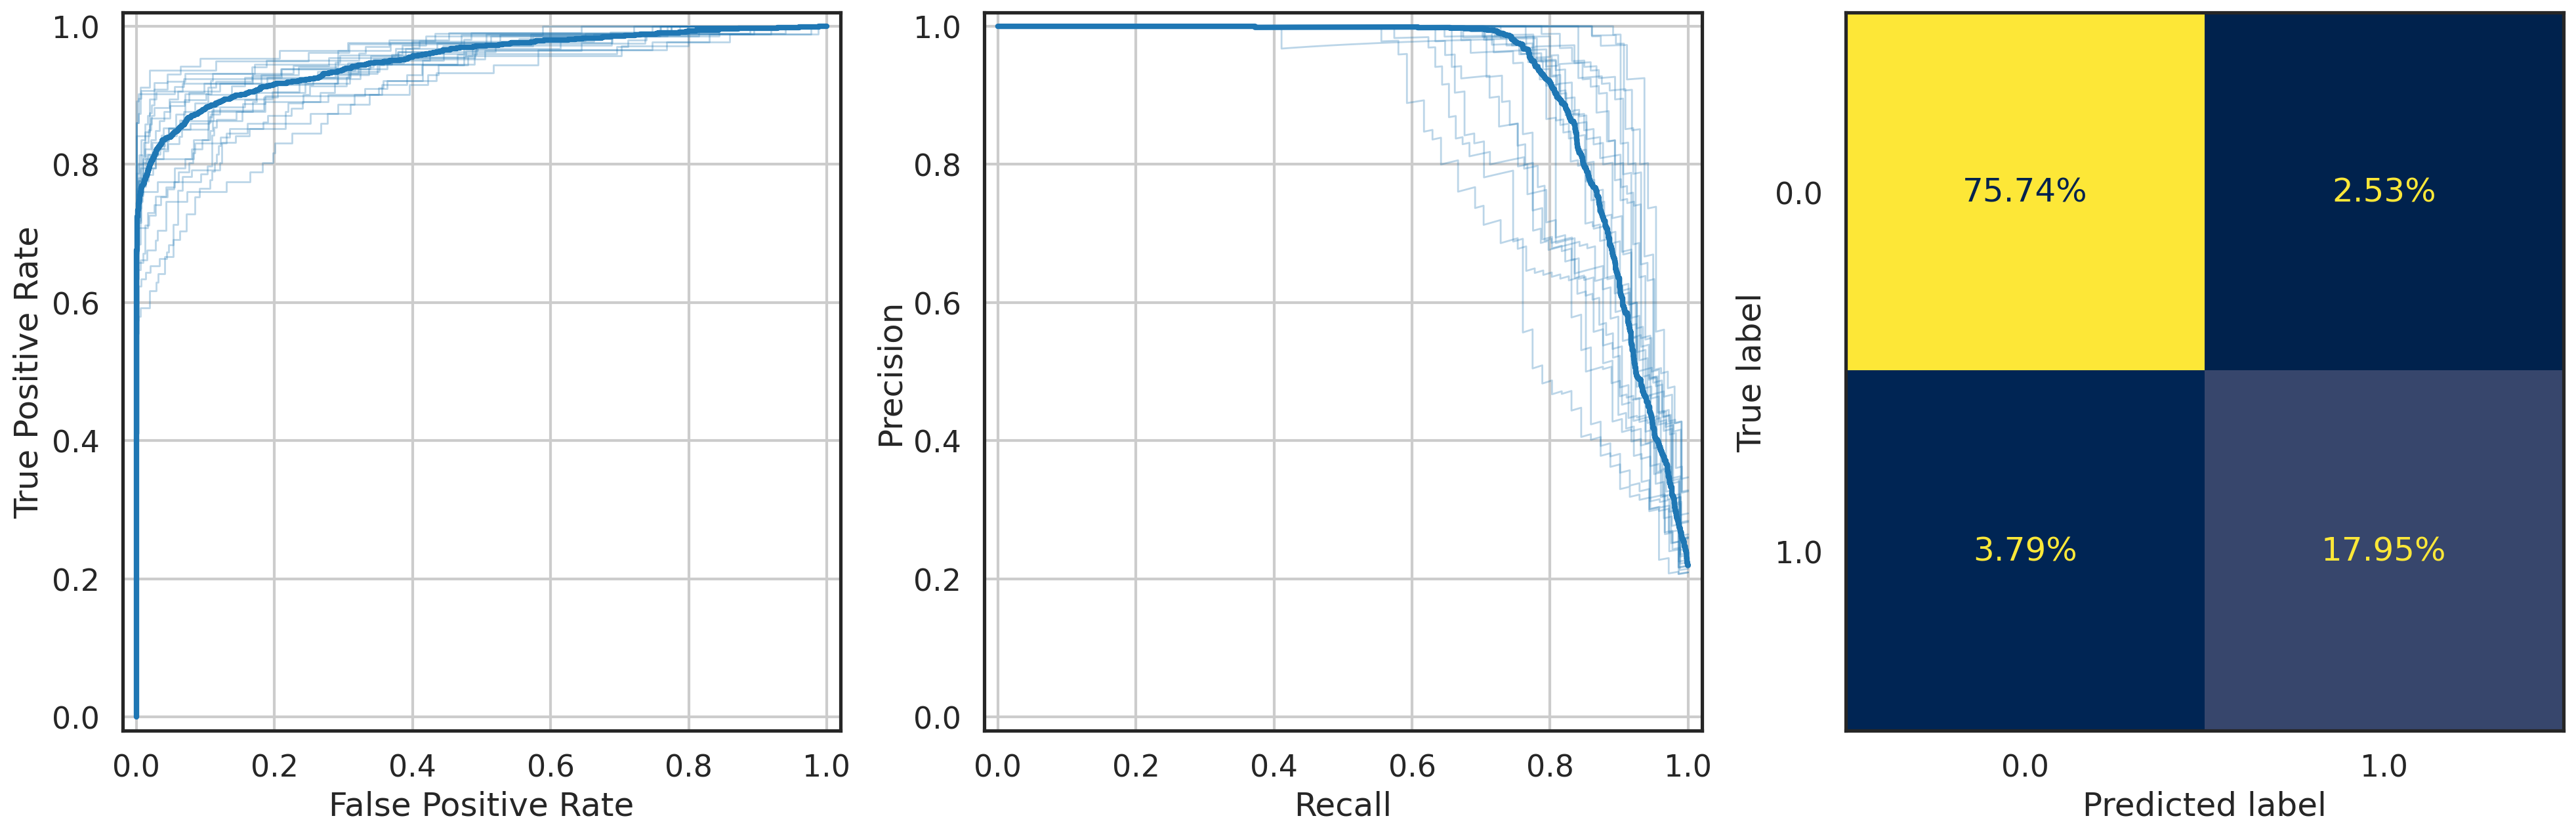

In [7]:
base = 'local/out/exp/' + ts
mkdirp(base)
print(base)

T.save(trained_reasoner.state_dict(), base+'/reasoner.pt')
df_tr = pd.DataFrame(train_logger.history_tr)
df_vl = pd.DataFrame(train_logger.history_vl)
df_tr.to_csv(base+'/train.csv', index=False)
df_vl.to_csv(base+'/valid.csv', index=False)
plot_train_history(df_tr, df_vl, save=base+'/train.png')

test_history_by_onto = pd.DataFrame(test_logger.history_vl_by_onto)
test_history = pd.DataFrame(test_logger.history_vl)
test_results = pd.DataFrame(dict(idx_te=idx_te, y_te=y_te, Y_te_good=Y_te_good))#, Y_te_rand=Y_te_rand))
test_history.to_csv(base+'/test.csv', index=False)
test_history_by_onto.to_csv(base+'/test-grouped.csv', index=False)
test_results.to_csv(base+'/test-results.csv', index=False)
plot_test_history(test_history, test_history_by_onto, save=base+'/test.png')
print(report(test_onto, y_te, np.array(Y_te_good), idx_te, save=base+'/%-trained'))
#print(report(test_onto, y_te, np.array(Y_te_rand), idx_te, save=base+'/%-random'))

In [8]:
T.set_printoptions(precision=4)

In [21]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    losses.append( F.l1_loss(input, trained_reasoner.and_nn(im_mod(input, input))).item() )


print(input)
print(trained_reasoner.and_nn(im_mod( input, input)))
print(np.mean(losses))

tensor([-0.1372,  0.0171,  0.1123, -0.1795,  0.1065,  0.1611, -0.0472,  0.1074,
        -0.1630,  0.1191], grad_fn=<SelectBackward0>)
tensor([-0.0136, -0.0484,  0.0172, -0.0211,  0.0664,  0.0012, -0.1111, -0.0005,
        -0.1723,  0.0569], grad_fn=<AddBackward0>)
0.10226672980934381


In [22]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    losses.append(F.l1_loss(trained_reasoner.and_nn(im_mod(trained_reasoner.bot_concept[0], input)), trained_reasoner.bot_concept[0]).item())
print(trained_reasoner.bot_concept[0])
print(trained_reasoner.and_nn(im_mod(trained_reasoner.bot_concept[0], input)))
print(np.mean(losses))

tensor([ 0.2549, -0.3716,  0.1933,  0.1638,  0.2481,  0.0573,  0.2503, -0.2899,
         0.0487, -0.0352], grad_fn=<SelectBackward0>)
tensor([ 0.2601, -0.3948,  0.2038,  0.1168,  0.2239,  0.0770,  0.2161, -0.2535,
         0.0380, -0.0554], grad_fn=<AddBackward0>)
0.023232801398262382


In [23]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    losses.append(F.l1_loss(trained_reasoner.and_nn(im_mod(trained_reasoner.top_concept[0], input)), input).item())

print(input)
print(trained_reasoner.and_nn(im_mod(trained_reasoner.top_concept[0], input)))
print(np.mean(losses))

tensor([ 0.0723, -0.0718,  0.0055,  0.0118,  0.0228, -0.1531, -0.1979,  0.3161,
         0.0057, -0.0846], grad_fn=<SelectBackward0>)
tensor([-0.0091,  0.0062,  0.0026, -0.0597, -0.0262, -0.0222, -0.1111,  0.1015,
        -0.0579, -0.0021], grad_fn=<AddBackward0>)
0.08211430758237839


In [12]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    output = trained_reasoner.and_nn(im_mod(trained_reasoner.not_nn(input), input))
    losses.append(F.l1_loss(trained_reasoner.bot_concept[0], output).item())

print(trained_reasoner.bot_concept[0])
print(output)
print(np.mean(losses))

tensor([ 0.2549, -0.3716,  0.1933,  0.1638,  0.2481,  0.0573,  0.2503, -0.2899,
         0.0487, -0.0352], grad_fn=<SelectBackward0>)
tensor([ 0.2612, -0.3588,  0.1662,  0.1787,  0.2531,  0.1341,  0.2627, -0.2532,
         0.0636, -0.0982], grad_fn=<AddBackward0>)
0.13373511601239443


In [24]:
print(trained_reasoner.bot_concept[0])
output = trained_reasoner.not_nn(trained_reasoner.top_concept[0])
print(output)
print(F.l1_loss(trained_reasoner.bot_concept[0], output))

tensor([ 0.2549, -0.3716,  0.1933,  0.1638,  0.2481,  0.0573,  0.2503, -0.2899,
         0.0487, -0.0352], grad_fn=<SelectBackward0>)
tensor([ 0.2549, -0.3715,  0.1934,  0.1641,  0.2481,  0.0572,  0.2502, -0.2898,
         0.0488, -0.0353], grad_fn=<SqueezeBackward3>)
tensor(8.7044e-05, grad_fn=<L1LossBackward0>)


In [25]:
print(trained_reasoner.top_concept[0])
output = trained_reasoner.not_nn(trained_reasoner.bot_concept[0])
print(output)
print(F.l1_loss(trained_reasoner.top_concept[0], output))

tensor([-0.3040,  0.0052, -0.2285, -0.1340, -0.2853, -0.4897,  0.2913, -0.1730,
         0.0350,  0.6079], grad_fn=<SelectBackward0>)
tensor([-0.3040,  0.0051, -0.2284, -0.1337, -0.2853, -0.4892,  0.2913, -0.1729,
         0.0349,  0.6079], grad_fn=<SqueezeBackward3>)
tensor(0.0001, grad_fn=<L1LossBackward0>)


In [15]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    input2 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    input3 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    losses.append(F.l1_loss(trained_reasoner.and_nn(im_mod(input1, trained_reasoner.and_nn(im_mod(input2, input3)))), trained_reasoner.and_nn(im_mod(trained_reasoner.and_nn(im_mod(input1, input2)), input3))).item())

print(trained_reasoner.and_nn(im_mod(input1, trained_reasoner.and_nn(im_mod(input2, input3)))))
print(trained_reasoner.and_nn(im_mod(trained_reasoner.and_nn(im_mod(input1, input2)), input3)))
print(np.mean(losses))

tensor([ 0.1216, -0.1841,  0.0895,  0.0351,  0.0708,  0.0078,  0.0393, -0.0788,
        -0.0955,  0.0138], grad_fn=<AddBackward0>)
tensor([ 0.1267, -0.1636,  0.0735,  0.0203,  0.0987,  0.0120,  0.0073, -0.0902,
        -0.0822, -0.0014], grad_fn=<AddBackward0>)
0.018123276601545512


In [16]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    input2 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    losses.append( F.l1_loss(trained_reasoner.and_nn(im_mod(input1, input2)), trained_reasoner.and_nn(im_mod(input2, input1))).item())

print(trained_reasoner.and_nn(im_mod(input1, input2)))
print(trained_reasoner.and_nn(im_mod(input2, input1)))

print(np.mean(losses))

tensor([-0.0085,  0.0306, -0.0014, -0.1179,  0.0122, -0.0618, -0.1855,  0.0301,
        -0.2167,  0.0840], grad_fn=<AddBackward0>)
tensor([-0.0057, -0.0215, -0.0089, -0.0955, -0.0096, -0.0177, -0.1387,  0.0630,
        -0.1984,  0.0736], grad_fn=<AddBackward0>)
0.02155561002437025


In [26]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    losses.append(F.l1_loss(input1, trained_reasoner.and_nn(im_mod(input1, trained_reasoner.top_concept[0]))).item())

print(input1)
print(trained_reasoner.and_nn(im_mod(input1, trained_reasoner.top_concept[0])))

print(np.mean(losses))

tensor([ 0.0508, -0.0229,  0.0353, -0.2647, -0.0216, -0.0820,  0.0680, -0.1653,
        -0.1625,  0.0946], grad_fn=<SelectBackward0>)
tensor([ 0.0183, -0.0394,  0.0144, -0.0920, -0.0161,  0.0011,  0.0003, -0.0524,
        -0.1023,  0.0453], grad_fn=<AddBackward0>)
0.06701509151607751


In [18]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    losses.append( T.sigmoid(trained_reasoner.sub_nn(im_mod(input1, trained_reasoner.top_concept[0]))).item())
print(np.mean(losses))

0.9992748618125915


In [27]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    losses.append(T.sigmoid(trained_reasoner.sub_nn(im_mod(trained_reasoner.bot_concept[0], trained_reasoner.bot_concept[0]))).item())
print(np.mean(losses))

0.9999490976333618


In [28]:
losses = []
for _ in range(20):
    encoder = encoders[int(np.round(random. random() * (len(encoders) - 1), 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    losses.append(T.sigmoid(trained_reasoner.sub_nn(im_mod(trained_reasoner.bot_concept[0], trained_reasoner.bot_concept[0]))).item())
print(np.mean(losses))

0.9999490976333618
